In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [2]:
import numpy as np
import torch
import pandas as pd
import torchvision
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import classification_report,f1_score,accuracy_score
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from random import randint

In [3]:
torch.cuda.is_available()

True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/datasets
%ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/13C2Ru1wAUMPosnWj0d55XMAqRU3_vfFd/datasets
cats_and_dogs_filtered/  cats_vs_dogs_dataset/  data_for_hw5/


In [5]:
%cp -r /content/drive/MyDrive/datasets/data_for_hw5/train /content/train
%cp -r /content/drive/MyDrive/datasets/data_for_hw5/test /content/test
%cp -r /content/drive/MyDrive/datasets/data_for_hw5/val /content/val

<h4>Классы в train, test, val сбалансированы</h4>

# Задача

<h3>Необходимо реализовать систему классификации лиц животных: кошек, собак и диких животных<h3>

#Подготовка данных под полносвязную сеть

## Custome datadet + **augmentation**

<h4>Я написал свой класс датасет и в getitem при обращении по индексу применил композицию трансформаций(которые имеют определенные вероятности) и тем самым на каждой эпохи при обращении по одному и тому же индексу я буду получать разные тензоры, тем самым реальных данных на входе в сеть будут поступать с определенными вероятностями. Вот так я реализовал аугментацию<h4>

In [6]:
class CustomeDataset(Dataset):

    def __init__(self,filepath,transform=None):
        self.data=torchvision.datasets.ImageFolder(filepath)
        self.transform=transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img,label=self.data[idx] #0-кошка, 1-собака, 2-дикое животное
        if self.transform:
            img=self.transform(img)
        return img,label

<h4>Так же размер картинок для полносвязных сетей будет 64x64, потому что если сделать их больше, например 224x224, то сеть возможно не справиться, потому что придется делать flatten и первый слой будет очень большой<h4>

In [ ]:
train_transform_for_fcn=transforms.Compose([
                     transforms.Resize((80,80)),
                     transforms.RandomCrop((64,64)),
                     transforms.ColorJitter(brightness=0.05,contrast=0.05,saturation=0.05,hue=0.05),
                     transforms.RandomHorizontalFlip(p=0.5), 
                     transforms.RandomRotation(20),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])           
])

<h4>С начала я обрезаю картинку, потом меняю яркость, контраст, насыщенность, оттенок, после деалаю mirroring, потом поворачиваю, перевожу в тензор и нормализирую<h4>

In [ ]:
test_transform_for_fcn=transforms.Compose([
                     transforms.Resize((64,64)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])           
])

In [7]:
inv_transform=transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
])

<h4>inv_transform нужен для вывода картинок<h4>

In [ ]:
train_cnn_data=CustomeDataset("/content/train",transform=train_transform_for_fcn)
test_cnn_data=CustomeDataset("/content/test",transform=test_transform_for_fcn)
val_cnn_data=CustomeDataset("/content/val",transform=test_transform_for_fcn)

## Show images function

In [8]:
def show_images(imgs,classes,network=None):
    plt.figure(figsize=(20,20))
    if network:
      network.eval()
      with torch.no_grad():
          for i in range(1,8,1):
            idx = randint(1, len(imgs)-2)
            plt.subplot(1,7,i)
            img=imgs.__getitem__(idx)[0]
            img=img.cuda()
            img=torch.reshape(img,(1,3,224,224))
            y_predicted=network(img)
            y_predicted=torch.argmax(y_predicted,axis=1).detach().cpu().numpy()
            plt.imshow(inv_transform(imgs.__getitem__(idx)[0]).permute(1, 2, 0))
            print(y_predicted)
            plt.title(f"{classes[y_predicted[0]]} предсказанное")
            right_label=imgs.__getitem__(idx)[1]
            if right_label==y_predicted[0]:
              plt.xlabel(f"{classes[right_label]} \n правильно предсказано")
            else:
              plt.xlabel(f"{classes[right_label]} \n неправильно предсказано")

    else:
      for i in range(1,6,1):
          idx = randint(1, len(imgs))
          plt.subplot(1,5,i)
          plt.imshow(inv_transform(imgs.__getitem__(idx)[0]).permute(1, 2, 0))
          plt.title(classes[imgs.__getitem__(idx)[1]])

In [9]:
classes={
    0:"cat",
    1:"dog",
    2:"wild"
}

##Images example

<h4>На первых картинках приведены  рандомно выбранные животные с применением к ним тарнсформаций. На вторых изображения приведена одна и та же картинка, но так как трансформации ее изменяют все они разные то есть аугментация<h4>

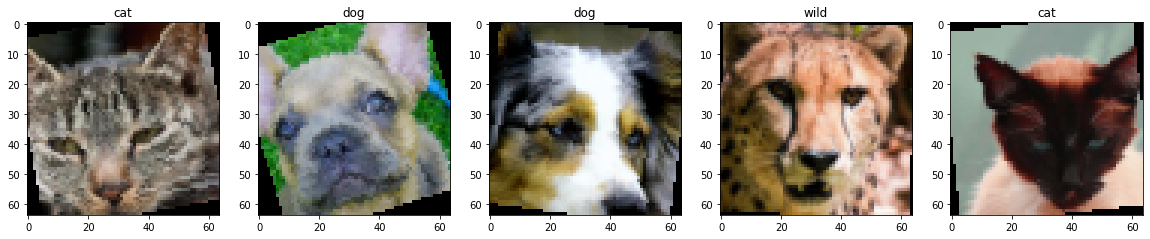

In [ ]:
show_images(train_cnn_data,classes)

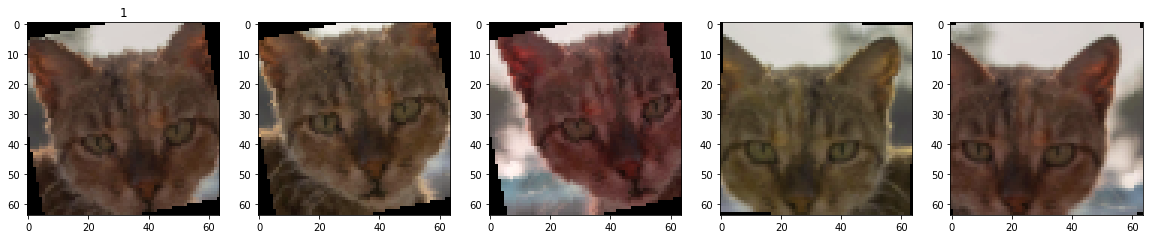

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.title(1)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,2)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,3)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,4)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,5)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))

## Dataloader

In [ ]:
train_cnn_loader=torch.utils.data.DataLoader(train_cnn_data,shuffle=True,batch_size=32,num_workers=2,pin_memory=True)
test_cnn_loader=torch.utils.data.DataLoader(test_cnn_data,shuffle=False,batch_size=64,num_workers=2,pin_memory=True)
val_cnn_loader=torch.utils.data.DataLoader(val_cnn_data,shuffle=False,batch_size=64,num_workers=2,pin_memory=True)

In [ ]:
def itr_merge(itrs):
    for itr in itrs:
        for v in itr:
            yield v

<h4>itr_merge - функция для объединения итераторов<h4>

# Train function

<h4>train_net нужна для того чтобы тренировать мою сеть. В качестве аргументов она принимает сеть, train и val данные, скорость обучения количество эпох, название сети и т.д.<h4>

In [10]:
def train_net(network,train_loader,val_loader,learning_rate=0.001,epochs=3,network_name=None,aug="No",total_batches=0,loaded_optimizer=None):
    optimizer=None
    if loaded_optimizer:
      optimizer=loaded_optimizer
    else:
      optimizer=torch.optim.AdamW(network.parameters(),lr=learning_rate) # Optimizer

    loss_fn=torch.nn.CrossEntropyLoss() # Функция стоимости
    best_accuracy=0
    errors=[] 
    errors_val=[]
    acc_val=[]
    network.train() # переводим сеть в состояние обучения
    
    for epoch in tqdm(range(epochs)):
        error=0
        if aug=="No":
            for x_batch,y_batch in tqdm(train_loader):

                x_batch=x_batch.cuda() # передаем данные на куду
                y_batch=y_batch.cuda() 

                optimizer.zero_grad()
                
                y_pred=network(x_batch)
                loss=loss_fn(y_pred,y_batch)
                
                error+=loss.item()

                loss.backward()

                optimizer.step()
        else:
            for x_batch,y_batch in tqdm(itr_merge(train_loader),total=total_batches):

                x_batch=x_batch.cuda()
                y_batch=y_batch.cuda()

                optimizer.zero_grad()

                y_pred=network(x_batch)

                loss=loss_fn(y_pred,y_batch)
                
                error+=loss.item()

                loss.backward()

                optimizer.step()          
            
        y_preds=[]
        y_trues=[]
        network.eval() #переводим сеть в состояние оценивание: исключаем слои, которые используются только train
        with torch.no_grad(): # временно устанавливает флаги requires_grad=False
            error_val=0
            for x_val,y_true in val_loader:
                x_val=x_val.cuda()    
                y_predicted=network(x_val)
                y_preds.append(torch.argmax(y_predicted,axis=1).detach().cpu().numpy())
                y_trues.append(y_true.detach().numpy())

                y_predicted=y_predicted.cuda()
                y_true=y_true.cuda()

                loss_val=loss_fn(y_predicted,y_true)
                error_val+=loss_val.item()
            errors_val.append(error_val)
            y_preds_union=y_preds[0]
            for arr in y_preds[1:]:
                y_preds_union=np.concatenate((y_preds_union,arr))

            y_true_union=y_trues[0]
            for arr in y_trues[1:]:
                y_true_union=np.concatenate((y_true_union,arr))   

            acc=accuracy_score(y_true_union,y_preds_union)
            acc_val.append(acc)
            if best_accuracy<acc:
                print(f'Save best model with accuracy {acc}')
                state = {
                        'state_dict': network.state_dict(),
                        'optimizer' : optimizer.state_dict()}
                if network_name:
                    torch.save(state, f"/content/drive/MyDrive/ML_models/hw5/{network_name}_best_model.pt") #Сохраняем наилучшую модель
                else:
                    torch.save(state, f"/content/drive/MyDrive/ML_models/hw5/best_model.pt")
                best_accuracy=acc
            else:
                print(f"Don't save model. Accuracy is {acc}")

        network.train()
        
        print(f"{epoch}: {error}")
        errors.append(error)
    return network,errors,errors_val,acc_val

# Test Function

<h4>Функция, которая тестирует сеть</h4>

In [11]:
def test_network(network,test_cnn_loader):
  network.eval()
  y_preds=[]
  y_trues=[]
  with torch.no_grad():
      for x_test,y_true in test_cnn_loader:
          x_test=x_test.cuda()    
          y_predicted=network(x_test)
          y_preds.append(torch.argmax(y_predicted,axis=1).detach().cpu().numpy())
          y_trues.append(y_true.detach().numpy())

      y_preds_union=y_preds[0]
      for arr in y_preds[1:]:
          y_preds_union=np.concatenate((y_preds_union,arr))

      y_true_union=y_trues[0]
      for arr in y_trues[1:]:
          y_true_union=np.concatenate((y_true_union,arr))  

      print(classification_report(y_true_union,y_preds_union))
      
  return 1

# Plot acc, error

<h4>Строит графики того как изменяется ошибка и точность на каждой эпохе</h4>

In [12]:
def plot_acc_error(train_error, val_error, val_accuracy):
  plt.figure(figsize=(20,5))

  plt.subplot(1,3,1)
  plt.plot(train_error)
  plt.title("Train")
  plt.xlabel("epoch")
  plt.ylabel("error")

  plt.subplot(1,3,2)
  plt.plot(val_error)
  plt.title("Val")
  plt.xlabel("epoch")
  plt.ylabel("error")

  plt.subplot(1,3,3)
  plt.plot(val_accuracy)
  plt.title("Val")
  plt.xlabel("epoch")
  plt.ylabel("acc")

# Полносвязная сеть

## Построение сети

In [ ]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet,self).__init__()
        self.fc1=torch.nn.Linear(12288,512)
        self.fc2=torch.nn.Linear(512,256)
        self.fc3=torch.nn.Linear(256,128)
        self.fc4=torch.nn.Linear(128,64)
        self.fc5=torch.nn.Linear(64,32)
        self.fc6=torch.nn.Linear(32,3)

        self.relu=torch.nn.ReLU()
        self.dropout=torch.nn.Dropout(p=0.1)
        self.batch_norm_l1=torch.nn.BatchNorm1d(512)
        self.batch_norm_l2=torch.nn.BatchNorm1d(256)
        self.batch_norm_l3=torch.nn.BatchNorm1d(128)
        self.batch_norm_l4=torch.nn.BatchNorm1d(64)
        self.batch_norm_l5=torch.nn.BatchNorm1d(32)

    def forward(self,x):
        x=torch.reshape(x,(-1,12288))
        x=self.dropout(self.relu(self.batch_norm_l1(self.fc1(x))))
        x=self.dropout(self.relu(self.batch_norm_l2(self.fc2(x))))
        x=self.dropout(self.relu(self.batch_norm_l3(self.fc3(x))))
        x=self.dropout(self.relu(self.batch_norm_l4(self.fc4(x))))
        x=self.dropout(self.relu(self.batch_norm_l5(self.fc5(x))))
        x=self.fc6(x)
        return x

In [ ]:
simple_net=SimpleNet().cuda()

## Тренировка

In [ ]:
final_net,errors_train,errors_val,acc_val=train_net(simple_net,train_cnn_loader,val_cnn_loader,network_name="SimpleNet",epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.6526666666666666
0: 363.6840623021126


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.6846666666666666
1: 320.37963712215424


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.6833333333333333
2: 302.8979493379593


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.724
3: 291.8328592181206


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.724
4: 285.279595464468


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.752
5: 278.26178073883057


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.7686666666666667
6: 270.61944618821144


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.7553333333333333
7: 264.92073065042496


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.7633333333333333
8: 262.12438264489174


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.762
9: 255.84314101934433


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.7713333333333333
10: 254.3028388917446


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.776
11: 249.4737958908081


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.7653333333333333
12: 247.76642537117004


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.7873333333333333
13: 242.46283823251724


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.784
14: 241.08219242095947


## Загрузка самой лучшей

In [ ]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/SimpleNet_best_model.pt")

In [ ]:
best_simple_model=SimpleNet().cuda()
best_simple_model.load_state_dict(state['state_dict'])
optimize_best_simple_model=state['optimizer']

## Оценка модели

In [ ]:
test_network(best_simple_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       0.64      0.86      0.74       495
           1       0.76      0.68      0.72       495
           2       0.79      0.60      0.68       495

    accuracy                           0.72      1485
   macro avg       0.73      0.72      0.71      1485
weighted avg       0.73      0.72      0.71      1485



1

<h4>Результаты получились довольно неплохие учитывая что это была всего лишь полносвязная сеть<h4>

<h4>Эти результаты я взял из тренировки модели и записал их вручную, так как колаб отключился и они все исчезли, а тренировать модель заново ради этого долго + лучшая модель все равно сохранена.<h4>

In [ ]:
errors_train=[363.68,320.37,302.89,291.83,285.27,278.26,270.61,264.92,262.12,255.84,254.30,249.47,247.76,242.46,241.08]
acc_val=[0.652,0.684,0.68,0.724,0.724,0.752,0.768,0.755,0.763,0.762,0.771,0.776,0.765,0.787,0.784]

Text(0, 0.5, 'acc')

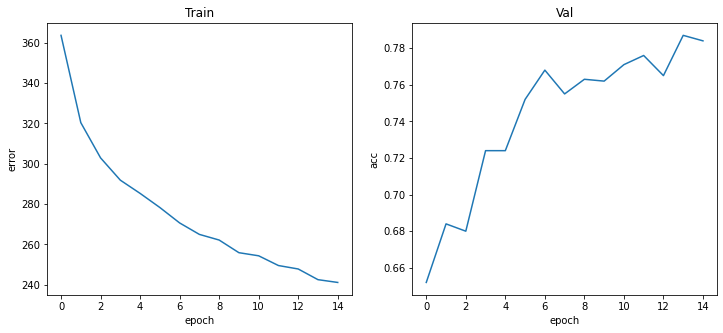

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(errors_train)
plt.title("Train")
plt.xlabel("epoch")
plt.ylabel("error")

plt.subplot(1,2,2)
plt.plot(acc_val)
plt.title("Val")
plt.xlabel("epoch")
plt.ylabel("acc")

Как видно из результатов на train ошибка падает, а а точность на val увеличивается.

<h4>Анализ на несколько предсказанных картинок<h4>

[2]
[0]
[0]
[0]
[0]
[1]
[0]


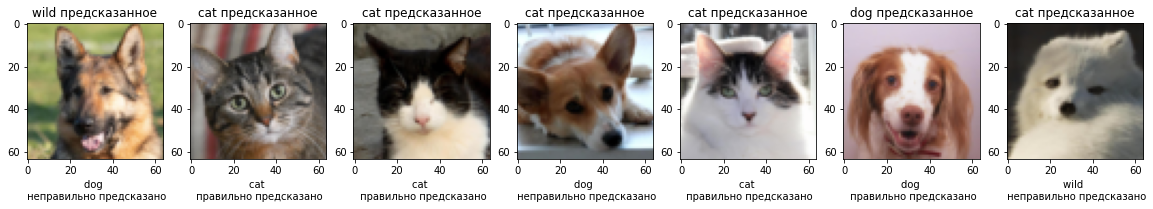

In [ ]:
show_images(test_cnn_data,classes,best_simple_model)

<h4>Как видно простая полносвязная сеть неплохо различет картинки, однако есть такие случаи когда вместо собаки предсказывает wild и наоборот, это логично потому что некоторые собаки похожи на волков, тоже самое с кошками и лисами.</h4>

# CNN с Res блоками

  ## Подготока данных под сверточную сеть

<h4>Так как сейчас в качестве модели будет использована cnn с res блоками, то размер картинки может быть 224x224</h4>

In [ ]:
train_transform_for_res_net=transforms.Compose([
                     transforms.Resize((280,280)),
                     transforms.RandomCrop((224,224)),
                     transforms.ColorJitter(brightness=0.05,contrast=0.05,saturation=0.05,hue=0.05),
                     transforms.RandomHorizontalFlip(p=0.5), 
                     transforms.RandomRotation(20),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])           
])

In [ ]:
test_transform_for_res_net=transforms.Compose([
                     transforms.Resize((224,224)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])           
])

In [ ]:
inv_transform=transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
])

In [ ]:
train_cnn_data=CustomeDataset("/content/train",transform=train_transform_for_res_net)
test_cnn_data=CustomeDataset("/content/test",transform=test_transform_for_res_net)
val_cnn_data=CustomeDataset("/content/val",transform=test_transform_for_res_net)

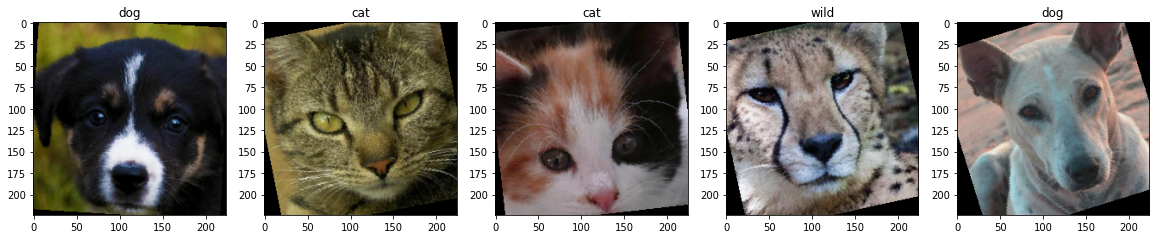

In [ ]:
show_images(train_cnn_data,classes)

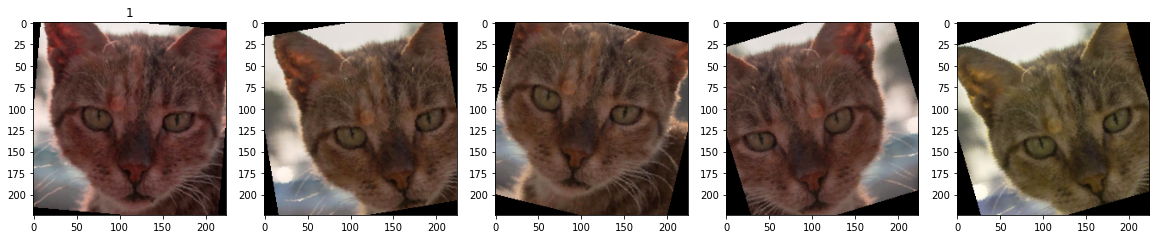

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.title(1)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,2)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,3)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,4)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))
plt.subplot(1,5,5)
plt.imshow(inv_transform(train_cnn_data.__getitem__(6)[0]).permute(1, 2, 0))

## Dataloader

In [ ]:
train_cnn_loader=torch.utils.data.DataLoader(train_cnn_data,shuffle=True,batch_size=32,num_workers=2,pin_memory=True)
test_cnn_loader=torch.utils.data.DataLoader(test_cnn_data,shuffle=False,batch_size=64,num_workers=2,pin_memory=True)
val_cnn_loader=torch.utils.data.DataLoader(val_cnn_data,shuffle=False,batch_size=64,num_workers=2,pin_memory=True)

## Построение сети

<h4>Я реализовывал ResBlock в стиле ReLU before addition<h4>

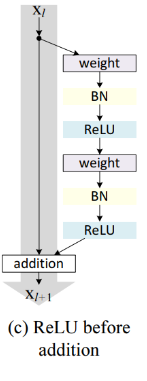

<h4>Cеть, которая состоит из Res Blocks, хороша тем, что она решает проблему с затухающими градиентами. То есть если сеть очень глубакая, то чтобы найти производную, которая находится где нибудь в начале, по выходу, нужно грубо говоря сделать очень много перемножний и тем самым эти производные могут быть равны 0, тем самым сеть перестанет обучаться, а с помощбю res блоков градиенты будут течь еще и через верхние слои и тем самым можно формировать очень глубокие сети</h4>

In [ ]:
class ConvBlock(torch.nn.Module):
  def __init__(self,in_c,out_c,**kwargs):
    super(ConvBlock,self).__init__()
    self.conv=torch.nn.Conv2d(in_c,out_c,**kwargs)
    self.bn=torch.nn.BatchNorm2d(out_c)
    self.relu=torch.nn.ReLU()
  def forward(self,x):
    return self.relu(self.bn(self.conv(x)))

In [ ]:
class ResBlock(torch.nn.Module):
  def __init__(self,in_c,out_c,kernel=3,stride=1,padding=0):
    super(ResBlock,self).__init__()
    self.conv1=ConvBlock(in_c,out_c,kernel_size=kernel,stride=stride,padding=padding)
    self.conv2=ConvBlock(out_c,out_c,kernel_size=kernel,stride=stride,padding=padding)
  def forward(self,x):
    out_1=self.conv1(x)
    x=self.conv2(out_1)
    x_out=x+out_1
    return x_out

In [ ]:
class SimpleResCNN(torch.nn.Module):
  def __init__(self):
    super(SimpleResCNN,self).__init__()
    self.res_block1=ResBlock(3,64,11,padding=5)
    self.res_block2=ResBlock(64,128,5,padding=2)
    self.res_block3=ResBlock(128,256,3,padding=1)
    self.res_block4=ResBlock(256,512,3,padding=1)
    self.res_block5=ResBlock(512,1024,3,padding=1)
    
    self.relu=torch.nn.ReLU()
    self.dropout=torch.nn.Dropout2d(0.1)
    self.flatten = torch.nn.Flatten()

    self.fc1=torch.nn.Linear(1024,128)
    self.fc2=torch.nn.Linear(128,16)
    self.fc3=torch.nn.Linear(16,3)
    self.dropout=torch.nn.Dropout(0.1)

    self.bn1=torch.nn.BatchNorm1d(128)
    self.bn2=torch.nn.BatchNorm1d(16)
    self.max_pool=torch.nn.MaxPool2d(3,stride=3,padding=1)

  def forward(self,x):
    x=self.max_pool(self.res_block1(x))
    x=self.max_pool(self.res_block2(x))
    x=self.max_pool(self.res_block3(x))
    x=self.max_pool(self.res_block4(x))
    x=self.max_pool(self.res_block5(x))
    x=self.flatten(x)
    x=self.dropout(self.relu(self.bn1(self.fc1(x))))
    x=self.dropout(self.relu(self.bn2(self.fc2(x))))
    x=self.fc3(x)
    return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

1645

In [ ]:
simple_res_cnn=SimpleResCNN().cuda()

## Тренировка

In [ ]:
final_net,errors_train,errors_val,acc_val=train_net(simple_res_cnn,train_cnn_loader,val_cnn_loader,network_name="SimpleResCNN",epochs=7)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faa5674cb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faa5674cb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Save best model with accuracy 0.7506666666666667
0: 208.13827691972256


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9046666666666666
1: 73.26783110946417


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9233333333333333
2: 48.70577802974731


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9686666666666667
3: 40.51115190424025


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9553333333333334
4: 31.545130279380828


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.976
5: 28.876958122011274


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9666666666666667
6: 24.976861405652016


## Загрузка самой лучшей

In [ ]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/SimpleResCNN_best_model.pt")

In [ ]:
best_simple_model=SimpleResCNN().cuda()
best_simple_model.load_state_dict(state['state_dict'])
optimize_best_simple_model=state['optimizer']

## Оценка модели

In [ ]:
test_network(best_simple_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       495
           1       0.91      0.99      0.95       495
           2       0.99      0.86      0.92       495

    accuracy                           0.95      1485
   macro avg       0.95      0.95      0.95      1485
weighted avg       0.95      0.95      0.95      1485



1

<h4>Как видно из результатов моя сеть с res блоками хорошо справилась с задачей классификации.<h4>

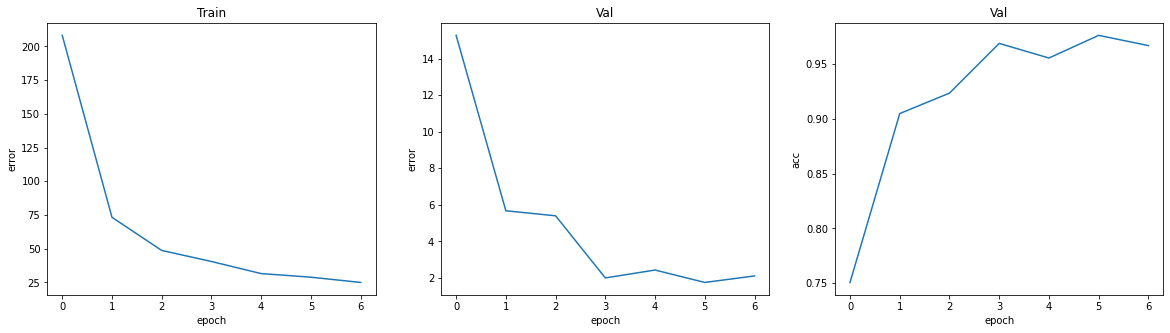

In [ ]:
plot_acc_error(errors_train,errors_val,acc_val)

<h4>Как видно из графиков error на train и val падает, а accuracy на val растет и почти выходит на плато<h4>

[2]
[0]
[1]
[0]
[2]
[1]
[1]


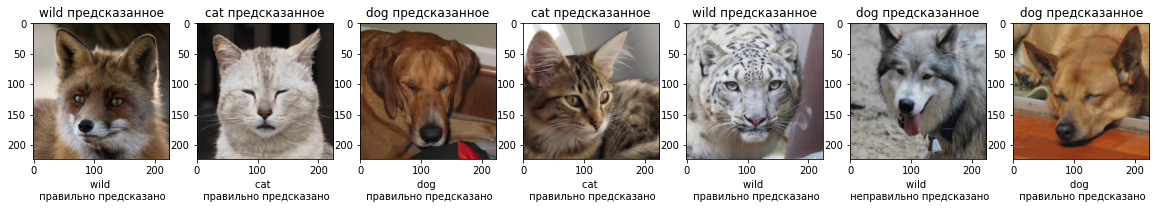

In [ ]:
show_images(test_cnn_data,classes,network=best_simple_model)

<h4>Как видно из результатов, нейросеть хорошо распознает картинки в высоком разрешении, хорошо отличает кошек от лис и собак от волков, однако иногда все равно происходят ошибки, но в примерах, в которых ошибается нейросеть, человек с высокой долей вероятности тоже бы ошибся, потому что так бывает что некоторые собаки очень похожи на собак, а лисы на котов.<h4>

# Custome Inception Network

<h4>Суть inception block в том, что он с помощью разных размеров свертки захватывают разные признаки изображений, а после их конкатенирует, тем самым мы получем больше информации о изображении</h4>

## Построение модели

<h3>Inseption Block<h3>

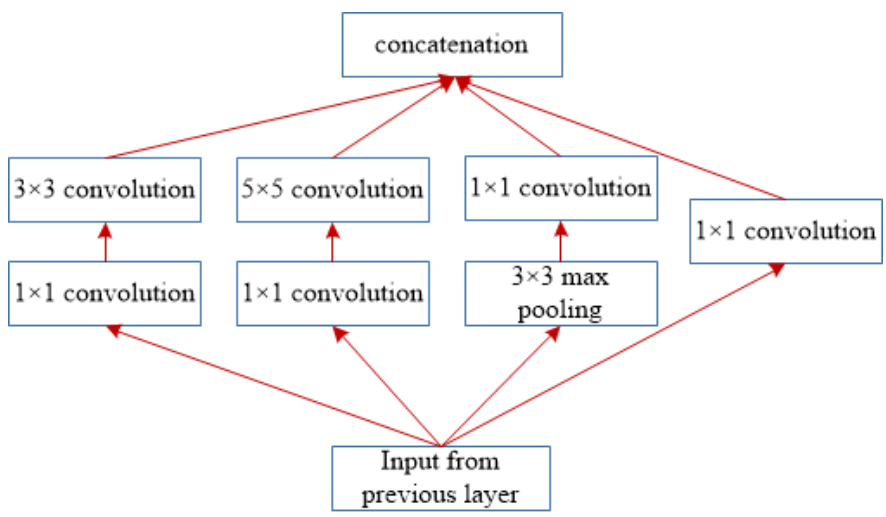

In [ ]:
class InceptionBlock(torch.nn.Module):

      def __init__(self,
                   in_c,
                   out_1x1,
                   red_3x3,
                   out_3x3,
                   red_5x5,
                   out_5x5,
                   out_max_pool
                   ):
        super(InceptionBlock,self).__init__()
        self.branch1=ConvBlock(in_c,out_1x1,kernel_size=1)
        self.branch2=torch.nn.Sequential(
            ConvBlock(in_c,red_3x3,kernel_size=1),
            ConvBlock(red_3x3,out_3x3,kernel_size=3,padding=1)
        )
        self.branch3=torch.nn.Sequential(
            ConvBlock(in_c,red_5x5,kernel_size=1),
            ConvBlock(red_5x5,out_5x5,kernel_size=5,padding=2)
        )
        self.branch4=torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            ConvBlock(in_c,out_max_pool,kernel_size=1)
        )
      
      def forward(self,x):
        branches=(self.branch1,self.branch2,self.branch3,self.branch4)
        return torch.cat([branch(x) for branch in branches],1)

In [ ]:
class ClassifierBlock(torch.nn.Module):

      def __init__(self,in_c,num_c):
        super(ClassifierBlock,self).__init__()
        self.avgpool=torch.nn.AvgPool2d(7,stride=2)
        self.fc1 = torch.nn.Linear(1024, num_c)
        self.dropout=torch.nn.Dropout(0.4)
        self.flatten=torch.nn.Flatten()
        self.relu=torch.nn.ReLU()

      def forward(self,x):
        x=self.avgpool(x)
        x=self.flatten(x)
        x=self.dropout(x)
        x=self.fc1(x)
        return x

<h4>InceptionNet архитектура, но я убрал промежуточные выходы<h4>

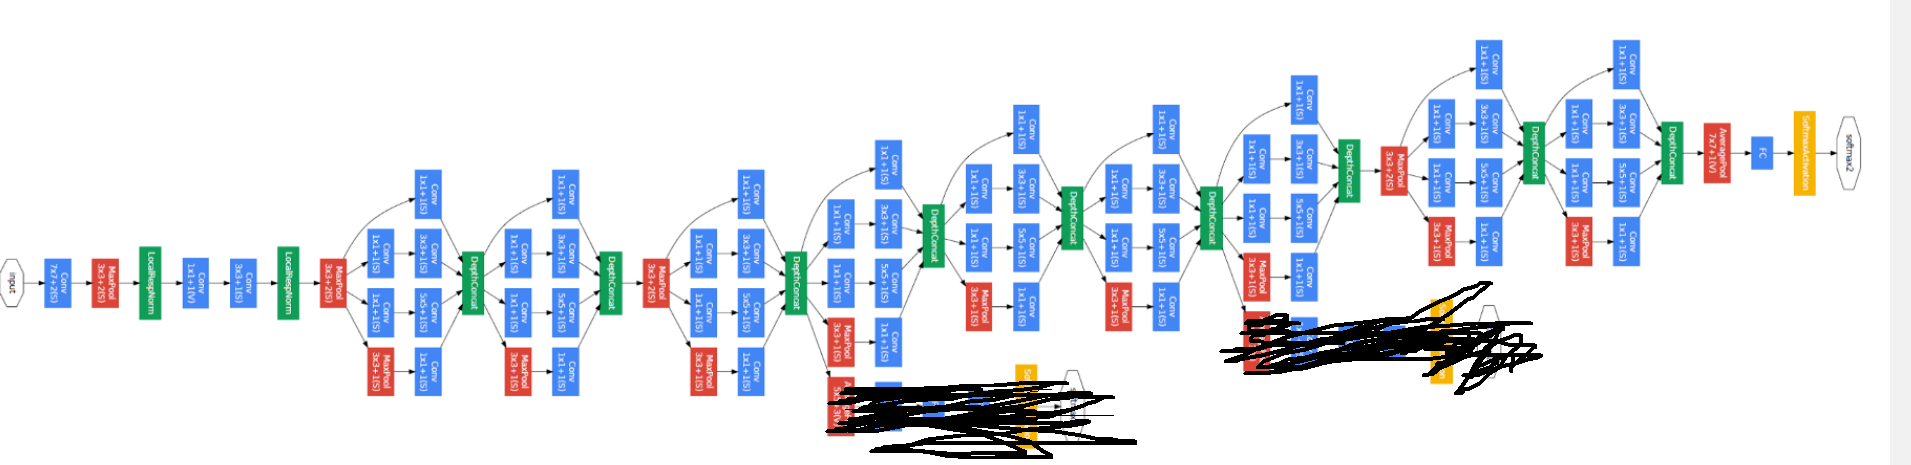

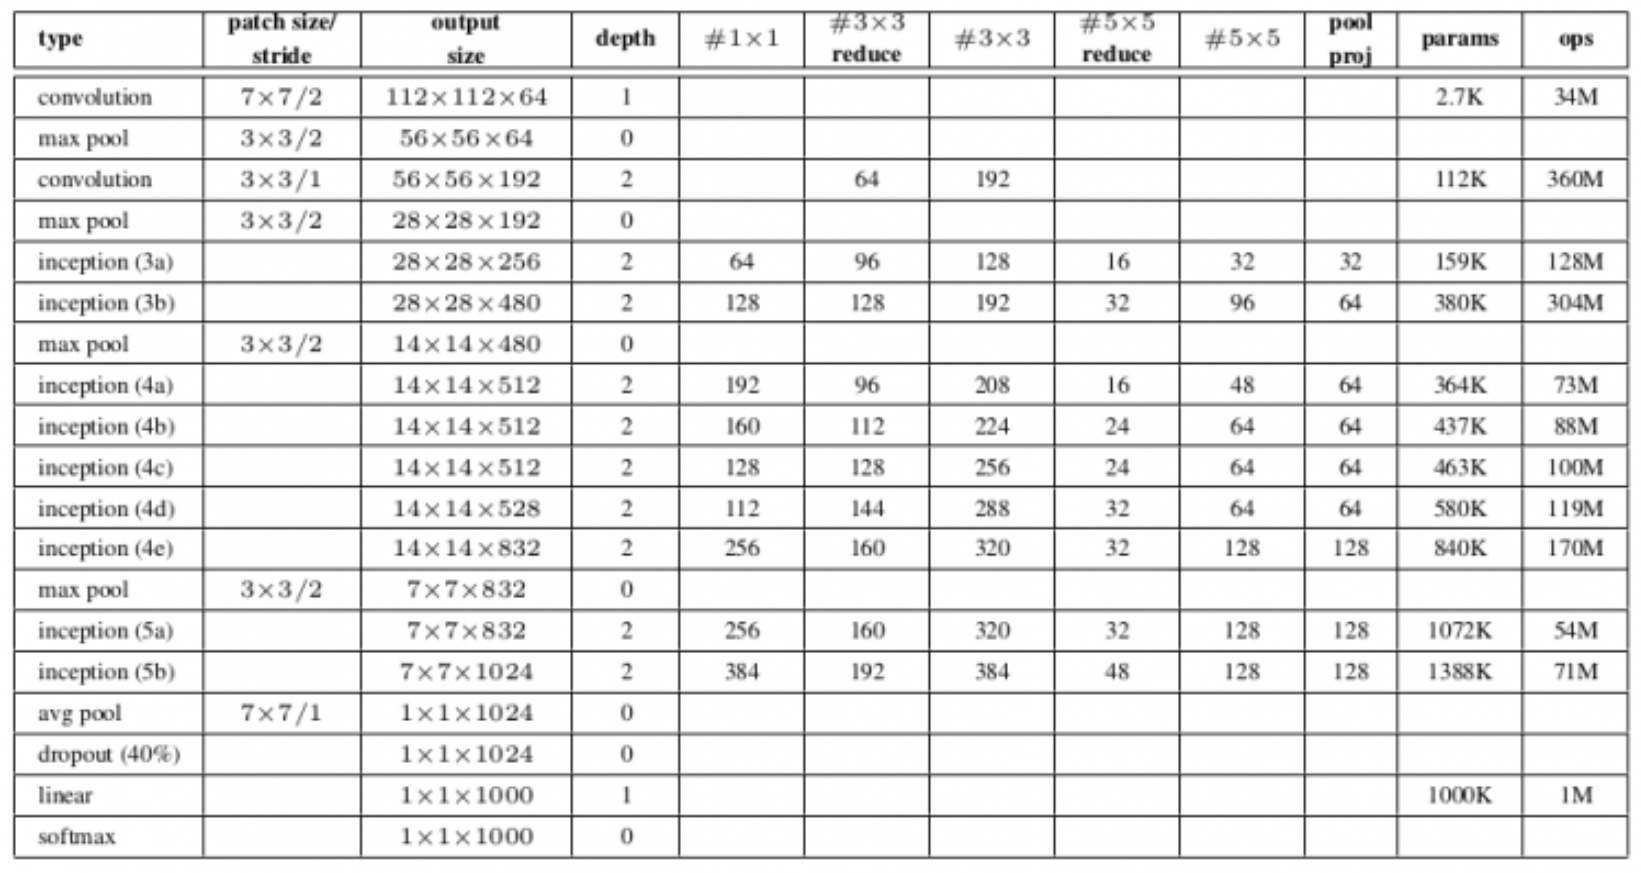

In [ ]:
class InceptionNet(torch.nn.Module):
    def __init__(self):
      super(InceptionNet,self).__init__()

      self.conv1=ConvBlock(3,64,kernel_size=7,stride=2,padding=3)
      self.max_pool=torch.nn.MaxPool2d(3,stride=2,padding=1)
      self.conv2=ConvBlock(64,192,kernel_size=3,stride=1,padding=1)

      self.inception3a=InceptionBlock(192,64,96,128,16,32,32)
      self.inception3b=InceptionBlock(256,128,128,192,32,96,64)

      self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
      self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
      self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
      self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
      self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

      self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
      self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

      self.classification_block=ClassifierBlock(1024,3)

    def forward(self,x):
      x=self.conv1(x)
      x=self.max_pool(x)
      x=self.conv2(x)
      x=self.max_pool(x)

      x = self.inception3a(x)
      x = self.inception3b(x)
      x = self.max_pool(x)

      x = self.inception4a(x)
      x = self.inception4b(x)
      x = self.inception4c(x)
      x = self.inception4d(x)
      x = self.inception4e(x)
      x = self.max_pool(x)

      x = self.inception5a(x)
      x = self.inception5b(x)

      x=self.classification_block(x)

      return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

414

In [ ]:
inception_net=InceptionNet().cuda()

## Тренировка

In [ ]:
final_net,errors_train,errors_val,acc_val=train_net(inception_net,train_cnn_loader,val_cnn_loader,network_name="InceptionNet",epochs=7)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.8593333333333333
0: 214.52875475212932


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9046666666666666
1: 77.01180143095553


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9413333333333334
2: 53.85924138920382


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.8913333333333333
3: 39.52844855119474


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.964
4: 34.394666713429615


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9653333333333334
5: 23.755867272033356


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.8793333333333333
6: 25.92591025668662


## Загрузка самой лучшей

In [ ]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/InceptionNet_best_model.pt")

In [ ]:
best_simple_model=InceptionNet().cuda()
best_simple_model.load_state_dict(state['state_dict'])
optimize_best_simple_model=state['optimizer']

## Оценка модели

In [ ]:
test_network(best_simple_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       495
           1       0.96      0.96      0.96       495
           2       0.96      0.94      0.95       495

    accuracy                           0.96      1485
   macro avg       0.96      0.96      0.96      1485
weighted avg       0.96      0.96      0.96      1485



1

<h4>На тесте результаты получились хорошие, нейросеть хорошо классифицирует объекты<h4>

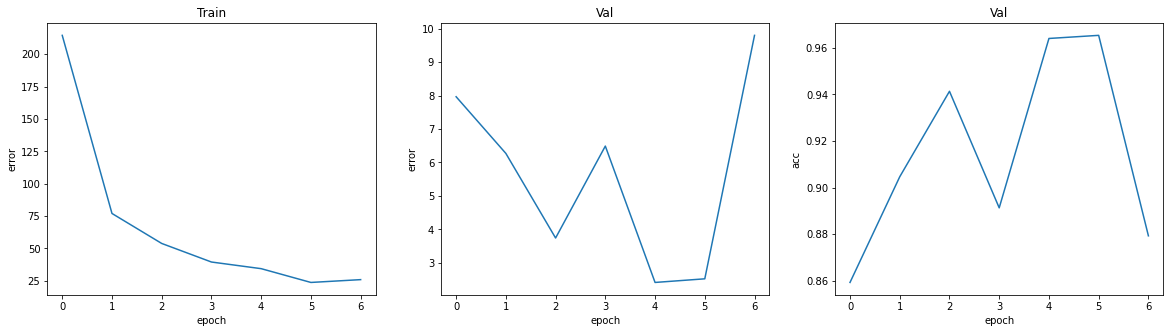

In [ ]:
plot_acc_error(errors_train,errors_val,acc_val)

<h4>Как видно из графиков на train ошибка падает, val error после 5 эпохи начинает сильно расти, что означает что сеть переобучилась и стоит прекратить обучение, val acc также растет до 5 эпохи, а потом падает.<h4>

[1]
[1]
[0]
[0]
[2]
[0]
[2]


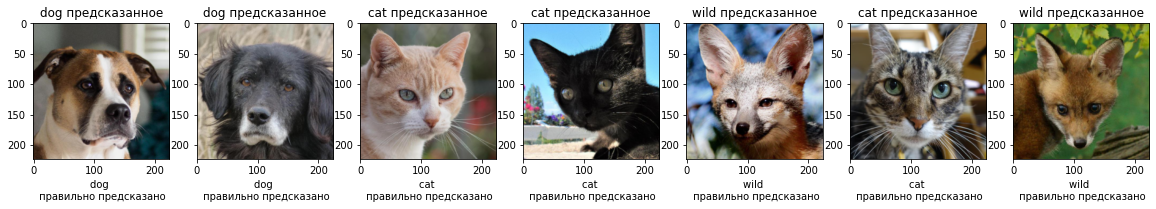

In [ ]:
show_images(test_cnn_data,classes,network=best_simple_model) 

<h4>Как видно из результатов, нейросеть хорошо распознает картинки в высоком разрешении, хорошо отличает кошек от лис и собак от волков, по результатам точность высокая, но не 100%, потому что все же находятся примеры, где кошки очень похожи на лисичек, а собаки на волков.<h4>

# Файнтюнинг крупных сверточных сетей

<h3>Суть:<p><h4>Замораживаются верхние (первые) слои сети, нижние дообучаются, так как первые слои выделяют низкоуровневую информацию, а последние выделяют информацию под мою конкретную задачу<h4><p> <h3>

## AlexNet

In [ ]:
from torchvision.models import alexnet

### Загрузка модели

In [ ]:
alex_net = alexnet(pretrained=True)

### Файнюнинг AlexNet

#### Удаление последнего слоя

<h4>Последний слой не нужен, удалим его<h4>

In [ ]:
alex_net.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

In [ ]:
alex_net.classifier=torch.nn.Sequential(*list(alex_net.classifier.children())[:-1])

In [ ]:
alex_net.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

<h4>Последний слой убран<h4>

#### Добавление слоев в сеть

In [ ]:
class MyAlexNet(torch.nn.Module):
    def __init__(self,network):
        super(MyAlexNet,self).__init__()
        self.fc1=torch.nn.Linear(4096,128)
        self.fc2=torch.nn.Linear(128,3)
        self.network=network
        for param in self.network.features.parameters():
            param.requires_grad=False

        self.dropout=torch.nn.Dropout(0.4)
        self.bn=torch.nn.BatchNorm1d(128)
        self.relu=torch.nn.ReLU()

    def forward(self,x):
        x=self.network(x)
        x=self.dropout(self.relu(self.bn(self.fc1(x))))
        x=self.fc2(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

449

In [ ]:
my_alex_net=MyAlexNet(alex_net).cuda()

### Тренировка

In [ ]:
final_net,errors_train,errors_val,acc_val=train_net(my_alex_net,train_cnn_loader,val_cnn_loader,network_name="MyAlexNet",epochs=7)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.988
0: 45.296545806806535


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.984
1: 25.83327053580433


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9853333333333333
2: 24.4419888301054


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9853333333333333
3: 22.925146147375926


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.99
4: 18.666547486616764


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.99
5: 19.195205730036832


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9926666666666667
6: 16.16212286252994


### Загрузка самой лучшей

In [ ]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/MyAlexNet_best_model.pt")

In [ ]:
best_simple_model=MyAlexNet(alex_net).cuda()
best_simple_model.load_state_dict(state['state_dict'])
optimize_best_simple_model=state['optimizer']

### Оценка модели

In [ ]:
test_network(best_simple_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       495
           1       0.99      1.00      0.99       495
           2       0.99      0.98      0.98       495

    accuracy                           0.99      1485
   macro avg       0.99      0.99      0.99      1485
weighted avg       0.99      0.99      0.99      1485



1

<h4>На тесте результаты получились очень хорошими, лучше чем любая другая не предобученная сеть, нейросеть хорошо классифицирует объекты<h4>

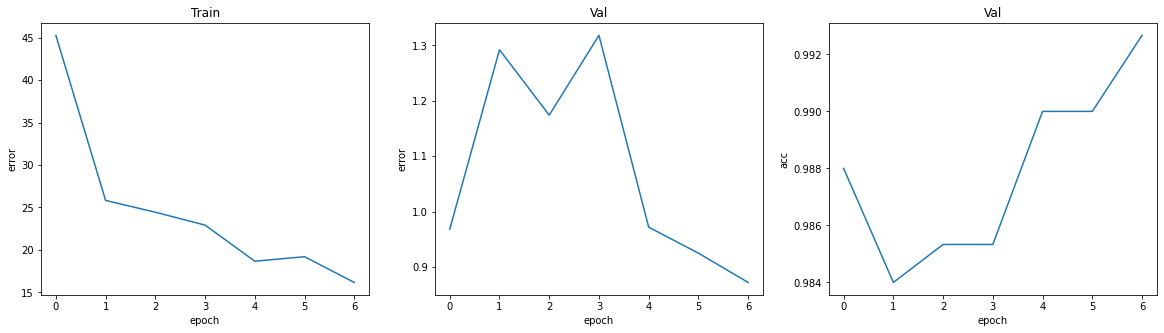

In [ ]:
plot_acc_error(errors_train,errors_val,acc_val)

<h4>Как видно из графиков на train и val ошибка падает, val acc растет. Все хорошо<h4>

[1]
[2]
[0]
[0]
[0]
[1]
[0]


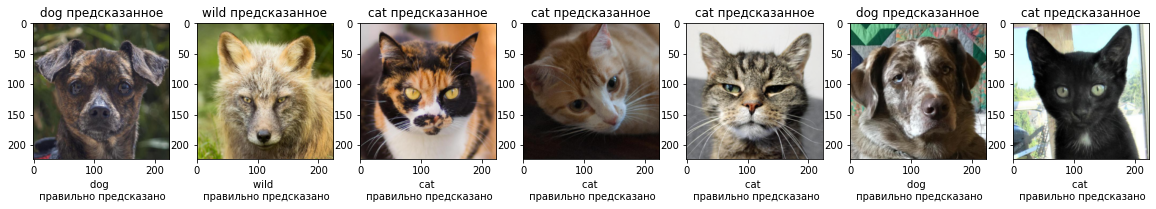

In [ ]:
show_images(test_cnn_data,classes,network=best_simple_model) 

<h4>Как видно из результатов, нейросеть практически идеально распознает картинки в высоком разрешении, хорошо отличает кошек от лис и собак от волков, по результатам точность высокая 0.99, но не 1, потому что все же находятся примеры, где кошки очень похожи на лисичек, а собаки на волков.<h4>

## Vgg16

In [13]:
from torchvision.models import vgg16

### Загрузка модели

In [14]:
vgg16 = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### Файнюнинг Vgg16

#### Удаление последнего слоя

<h4>Последний слой не нужен, удалим его</h4>

In [15]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [16]:
vgg16.classifier=torch.nn.Sequential(*list(vgg16.classifier.children())[:-1])

In [17]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

<h4>Последний слой убран<h4>

#### Добавление слоев в сеть

In [18]:
class MyVgg16(torch.nn.Module):
    def __init__(self,network):
        super(MyVgg16,self).__init__()
        self.fc1=torch.nn.Linear(4096,128)
        self.fc2=torch.nn.Linear(128,3)
        self.network=network
        for param in self.network.features.parameters():
            param.requires_grad=False

        self.dropout=torch.nn.Dropout(0.4)
        self.bn=torch.nn.BatchNorm1d(128)
        self.relu=torch.nn.ReLU()

    def forward(self,x):
        x=self.network(x)
        x=self.dropout(self.relu(self.bn(self.fc1(x))))
        x=self.fc2(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

301

### Тренировка

In [ ]:
my_vgg16=MyVgg16(vgg16).cuda()

In [ ]:
final_net,errors_train,errors_val,acc_val=train_net(my_vgg16,train_cnn_loader,val_cnn_loader,network_name="MyVgg16",epochs=7)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9953333333333333
0: 24.11894540465437


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9953333333333333
1: 11.85371449039667


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9953333333333333
2: 10.351179035147652


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9953333333333333
3: 7.556940106616821


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9973333333333333
4: 7.29517660322017


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.996
5: 6.8924403818527935


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.998
6: 6.467290188695188


### Загрузка самой лучшей

In [ ]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/MyVgg16_best_model.pt")

In [ ]:
best_simple_model=MyVgg16(vgg16).cuda()
best_simple_model.load_state_dict(state['state_dict'])
optimize_best_simple_model=state['optimizer']

### Оценка модели

In [ ]:
test_network(best_simple_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       495
           1       0.99      1.00      1.00       495
           2       1.00      0.99      1.00       495

    accuracy                           1.00      1485
   macro avg       1.00      1.00      1.00      1485
weighted avg       1.00      1.00      1.00      1485



1

<h4>На тесте результаты получились очень хорошими, лучше чем любая другая не предобученная сеть, нейросеть хорошо классифицирует объекты<h4>

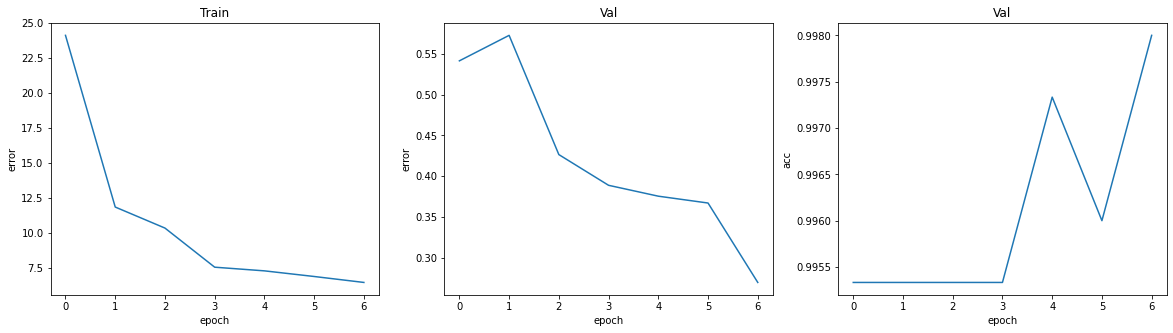

In [ ]:
plot_acc_error(errors_train,errors_val,acc_val)

<h4>Как видно из графиков на train и val ошибка падает, val acc растет. Все хорошо<h4>

[1]
[2]
[2]
[2]
[1]
[2]
[2]


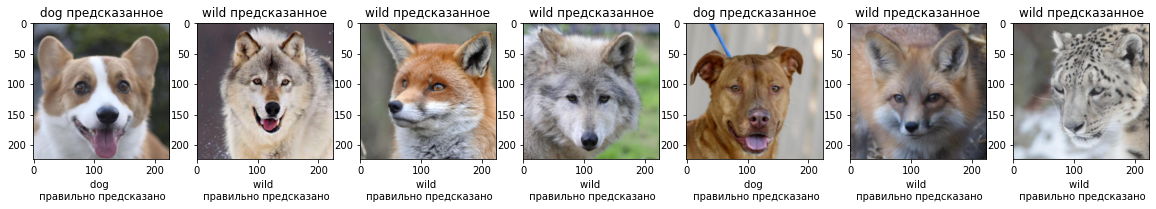

In [ ]:
show_images(test_cnn_data,classes,network=best_simple_model) 

<h4>Как видно из результатов, нейросеть идеально распознает картинки в высоком разрешении, хорошо отличает кошек от лис и собак от волков.

# Дистилляция

<h3>Суть:<p><h4>В реальности очень большие модели, например такие как vgg16 очень тяжело интегрировать в продакшен, одна из причин это огромный вес модели. Поэтому придумали подход, благодаря которому маленькая модель может получить похожие результаты как и большая. В начале мы обучем большую модель на основе наших данных, потом тренируем маленькую модель на основе тех же данных в связке с этой большой сетью и интегрируем в продакшен маленькую модель. В качестве учителя будет выступать vgg16, а в качестве ученика полносвязная сеть, которая была реализована в начале</h4></p></h3>

## Подготовка данных

In [19]:
train_transform_for_cnn=transforms.Compose([
                     transforms.Resize((280,280)),
                     transforms.RandomCrop((224,224)),
                     transforms.ColorJitter(brightness=0.05,contrast=0.05,saturation=0.05,hue=0.05),
                     transforms.RandomHorizontalFlip(p=0.5), 
                     transforms.RandomRotation(20),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])           
])

In [20]:
test_transform_for_cnn=transforms.Compose([
                     transforms.Resize((224,224)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])           
])

In [21]:
inv_transform=transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
])

In [22]:
train_cnn_data=CustomeDataset("/content/train",transform=train_transform_for_cnn)
test_cnn_data=CustomeDataset("/content/test",transform=test_transform_for_cnn)
val_cnn_data=CustomeDataset("/content/val",transform=test_transform_for_cnn)

In [23]:
train_cnn_loader=torch.utils.data.DataLoader(train_cnn_data,shuffle=True,batch_size=32,num_workers=2,pin_memory=True)
test_cnn_loader=torch.utils.data.DataLoader(test_cnn_data,shuffle=False,batch_size=64,num_workers=2,pin_memory=True)
val_cnn_loader=torch.utils.data.DataLoader(val_cnn_data,shuffle=False,batch_size=64,num_workers=2,pin_memory=True)

## Модель учителя

<h4>В качестве модели учителя возьмем vgg16, так как она дала самые лучшие результаты на тестовых данных</h4>

In [24]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/MyVgg16_best_model.pt")

In [25]:
teacher_model=MyVgg16(vgg16).cuda()
teacher_model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [26]:
test_network(teacher_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       495
           1       0.99      1.00      1.00       495
           2       1.00      0.99      1.00       495

    accuracy                           1.00      1485
   macro avg       1.00      1.00      1.00      1485
weighted avg       1.00      1.00      1.00      1485



1

## Модель ученика

<h4>В качестве модели ученика возьму простую маленькую сверточную сеть</h4>

In [28]:
class StudentModel(torch.nn.Module):
    def __init__(self):
        super(StudentModel,self).__init__()
        self.conv1 = torch.nn.Conv2d(3,32,5)
        self.conv2 = torch.nn.Conv2d(32,64,3)
        self.conv3 = torch.nn.Conv2d(64,64,3)

        self.flatten = torch.nn.Flatten()

        self.fc1=torch.nn.Linear(40000,16)
        self.fc2=torch.nn.Linear(16,3)

        self.relu=torch.nn.ReLU()
        self.dropout=torch.nn.Dropout(p=0.4)
        self.batch_norm_l1=torch.nn.BatchNorm1d(16)

        self.bn1=torch.nn.BatchNorm2d(32)
        self.bn2=torch.nn.BatchNorm2d(64)
        self.bn3=torch.nn.BatchNorm2d(64)

        self.max_pool=torch.nn.MaxPool2d(3,2)

    def forward(self,x):
        x=self.max_pool(self.bn1(self.relu(self.conv1(x))))
        x=self.max_pool(self.bn2(self.relu(self.conv2(x))))
        x=self.max_pool(self.bn3(self.relu(self.conv3(x))))

        x=self.flatten(x)
        x=self.dropout(self.relu(self.batch_norm_l1(self.fc1(x))))
        x=self.fc2(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

1255

In [ ]:
studentmodel=StudentModel().cuda()

### Обучение ученика(нужно просто для сравнения результатов в будущем)

<h4>Обучим модель студента пока отдельно, чтобы посмотреть какие результаты дает модель, чтобы в будущем после обучения этой же модели в связке с учителем можно было сравнить результаты<h4>

In [ ]:
final_net,errors_train,errors_val,acc_val=train_net(studentmodel,train_cnn_loader,val_cnn_loader,network_name="StudentModel",epochs=12)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.962
0: 70.85472631454468


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9706666666666667
1: 46.69455445371568


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9773333333333334
2: 37.94099356746301


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.976
3: 31.28278223029338


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9733333333333334
4: 27.765207503456622


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9706666666666667
5: 30.234571779612452


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9733333333333334
6: 25.209282824594993


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9806666666666667
7: 23.11420955506037


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9806666666666667
8: 20.42771553521743


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9766666666666667
9: 21.006828879821114


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9773333333333334
10: 19.189650734362658


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9793333333333333
11: 17.113821542618098


### Загрузка самой лучшей

In [ ]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/StudentModel_best_model.pt")

In [ ]:
best_simple_model=StudentModel().cuda()
best_simple_model.load_state_dict(state['state_dict'])
optimize_best_simple_model=state['optimizer']

### Оценка модели

In [ ]:
test_network(best_simple_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       495
           1       0.87      0.99      0.93       495
           2       0.98      0.85      0.91       495

    accuracy                           0.94      1485
   macro avg       0.95      0.94      0.94      1485
weighted avg       0.95      0.94      0.94      1485



1

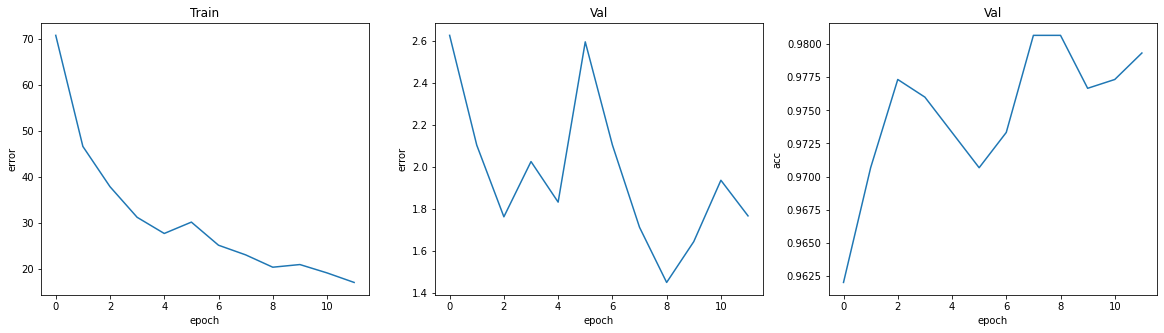

In [ ]:
plot_acc_error(errors_train,errors_val,acc_val)

## Функции дистилляции

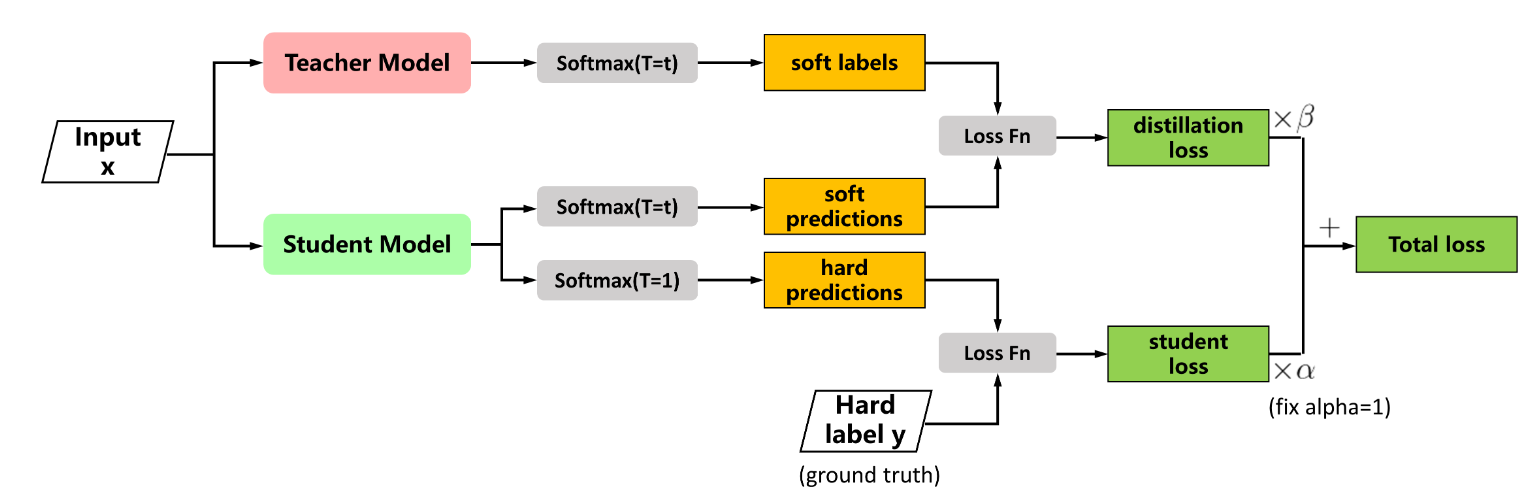

<h4>Как показанно на схеме функция стоимости состоит из суммы CE и дивергенции кульбака-лейблера умноженные на свои коэффициенты. В CE в качестве правидьных результатов hard label, то есть one-hot-vector, а в KL подается в качестве правильных результатов soft label модели учителя</h4>

<h4>Также softmax не обычный, а с сглаживающим параметром</h4>

In [36]:
def loss_fn_kd(outputs,labels,teacher_output,alpha,T):
  ce_loss=torch.nn.CrossEntropyLoss()
  kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
  log_softmax=torch.nn.LogSoftmax(dim=1)
  softmax=torch.nn.Softmax(dim=1)
  loss = ce_loss(outputs,labels)*(1.-alpha) +  kl_loss(log_softmax(outputs/T),softmax(teacher_output/T))*(alpha*T*T)
  return loss

## Train distillation

In [34]:
def train_kd(network, teacher_model, optimizer, loss_fn_kd, train_loader, val_loader, alpha, T,aug="No",total_batches=0,epochs=3,network_name=None):
    loss_fn=torch.nn.CrossEntropyLoss()
    best_accuracy=0
    errors=[] 
    errors_val=[]
    acc_val=[]
    network.train() # переводим сеть в состояние обучения
    teacher_model.eval()
    for epoch in tqdm(range(epochs)):
        error=0
        if aug=="No":
            for x_batch,y_batch in tqdm(train_loader):

                x_batch=x_batch.cuda() # передаем данные на куду
                y_batch=y_batch.cuda() 

                optimizer.zero_grad()
                
                y_pred=network(x_batch)

                with torch.no_grad():
                  y_pred_teacher=teacher_model(x_batch)
                y_pred_teacher.requires_grad=False
                loss=loss_fn_kd(y_pred,y_batch,y_pred_teacher,alpha,T) # Функция стоимости для KD
                
                error+=loss.item()

                loss.backward()

                optimizer.step()
        else:
            for x_batch,y_batch in tqdm(itr_merge(train_loader),total=total_batches):

                x_batch=x_batch.cuda()
                y_batch=y_batch.cuda()

                optimizer.zero_grad()

                y_pred=network(x_batch)

                with torch.no_grad():
                  y_pred_teacher=teacher_model(x_batch)
                y_pred_teacher.requires_grad=False

                loss=loss_fn_kd(y_pred,y_batch,y_pred_teacher,alpha,T)
                
                error+=loss.item()

                loss.backward()

                optimizer.step()          
            
        y_preds=[]
        y_trues=[]
        network.eval() #переводим сеть в состояние оценивание: исключаем слои, которые используются только train
        with torch.no_grad(): # временно устанавливает флаги requires_grad=False
            error_val=0
            for x_val,y_true in val_loader:
                x_val=x_val.cuda()    
                y_predicted=network(x_val)
                y_preds.append(torch.argmax(y_predicted,axis=1).detach().cpu().numpy())
                y_trues.append(y_true.detach().numpy())

                y_predicted=y_predicted.cuda()
                y_true=y_true.cuda()

                loss_val=loss_fn(y_predicted,y_true)
                error_val+=loss_val.item()
            errors_val.append(error_val)
            y_preds_union=y_preds[0]
            for arr in y_preds[1:]:
                y_preds_union=np.concatenate((y_preds_union,arr))

            y_true_union=y_trues[0]
            for arr in y_trues[1:]:
                y_true_union=np.concatenate((y_true_union,arr))   

            acc=accuracy_score(y_true_union,y_preds_union)
            acc_val.append(acc)
            if best_accuracy<acc:
                print(f'Save best model with accuracy {acc}')
                state = {
                        'state_dict': network.state_dict(),
                        'optimizer' : optimizer.state_dict()}
                if network_name:
                    torch.save(state, f"/content/drive/MyDrive/ML_models/hw5/{network_name}_best_model.pt") #Сохраняем наилучшую модель
                else:
                    torch.save(state, f"/content/drive/MyDrive/ML_models/hw5/best_model.pt")
                best_accuracy=acc
            else:
                print(f"Don't save model. Accuracy is {acc}")

        network.train()
        
        print(f"{epoch}: {error}")
        errors.append(error)
    return network,errors,errors_val,acc_val

## Обучение

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

359

In [ ]:
student_model=StudentModel().cuda()
optimizer=torch.optim.Adam(student_model.parameters(),lr=0.001)

In [ ]:
final_net,errors_train,errors_val,acc_val=train_kd(student_model,teacher_model,optimizer,loss_fn_kd,train_cnn_loader,val_cnn_loader,0.2,1.5,epochs=10,network_name="SimpleNetWithTeacher")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9573333333333334
0: 197.64294657111168


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.96
1: 84.22925421595573


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9726666666666667
2: 67.70377333462238


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.976
3: 50.554766772314906


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9753333333333334
4: 46.670668247155845


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9773333333333334
5: 40.202512016985565


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.976
6: 35.148949726484716


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9826666666666667
7: 33.779106913134456


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9726666666666667
8: 31.111153373029083


  0%|          | 0/411 [00:00<?, ?it/s]

Don't save model. Accuracy is 0.9773333333333334
9: 28.65331769688055


## Загрузка самой лучшей

In [ ]:
state=torch.load("/content/drive/MyDrive/ML_models/hw5/SimpleNetWithTeacher_best_model.pt")

In [ ]:
best_simple_model=StudentModel().cuda()
best_simple_model.load_state_dict(state['state_dict'])
optimize_best_simple_model=state['optimizer']

## Оценка модели

In [ ]:
test_network(best_simple_model,test_cnn_loader)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       495
           1       0.93      0.99      0.96       495
           2       0.97      0.92      0.94       495

    accuracy                           0.96      1485
   macro avg       0.96      0.96      0.96      1485
weighted avg       0.96      0.96      0.96      1485



1

<h4>На тесте результаты с дистилляцией получились лучше чем без нее. Accuracy лучше на 2%, macro avg лучше на 2%. Что и требовалось доказать, я с помощью дистилляции смог приблизиться по результатам к vgg, при этом student network намного меньше чем vgg16<h4>

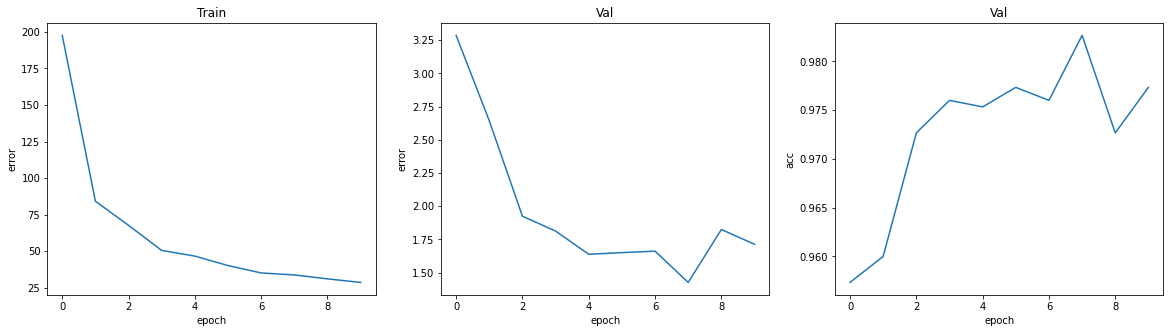

In [ ]:
plot_acc_error(errors_train,errors_val,acc_val)

<h4>Как видно из графиков на train и val ошибка падает, val acc растет. Все хорошо<h4>

[1]
[2]
[0]
[2]
[1]
[0]
[0]


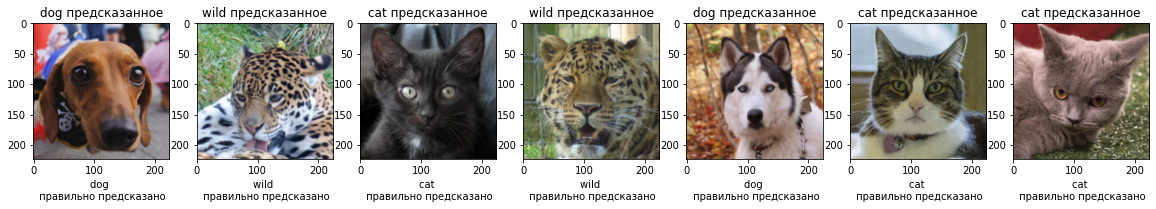

In [ ]:
show_images(test_cnn_data,classes,network=best_simple_model) 

<h4>Как видно из результатов, нейросеть хорошо распознает картинки в высоком разрешении, хорошо отличает кошек от лис и собак от волков.</h4>

# Квантизация

<h3>Суть:<p><h4>Окруляем все до каких либо значений, то есть допустим веса были в float32, а стали int8. То есть мы делам сеть легкой. </h4></p></h3>

In [44]:
student_model_1=StudentModel().cuda()
optimizer=torch.optim.Adam(student_model_1.parameters(),lr=0.001)

In [ ]:
student_model_int8=torch.quantization.quantize_dynamic(
    student_model_1,
    {torch.nn.Linear},
    dtype=torch.qint8
)

In [ ]:
student_model_int8=student_model_int8.cuda()

<h4>К сожалению динамическое квантование не поддерживает CUDA, поэтому в связке дистилляция + прунинг квантизация не используется</h4>

# Прунинг

<h3>Суть:<p><h4>Выкинуть какой то процент весов, тем самым сделать сеть меньше и легче </h4></p></h3>

In [45]:
import torch.nn.utils.prune as prune

In [46]:
module_1=student_model_1.conv1
module_2=student_model_1.conv2
module_3=student_model_1.conv3

In [47]:
prune.random_unstructured(module_1, name="weight", amount=0.05)
prune.random_unstructured(module_2, name="weight", amount=0.05)
prune.random_unstructured(module_3, name="weight", amount=0.05)

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

# Дистиляция + Прунинг(Кантизация на cuda не поддерживается)

## Обучение модели

In [48]:
final_net,errors_train,errors_val,acc_val=train_kd(student_model_1,teacher_model,optimizer,loss_fn_kd,train_cnn_loader,val_cnn_loader,0.2,1.5,epochs=4,network_name="DistillationPruningNN")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.92
0: 273.4212103486061


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.94
1: 168.05041927099228


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.944
2: 130.61229755729437


  0%|          | 0/411 [00:00<?, ?it/s]

Save best model with accuracy 0.9473333333333334
3: 114.86560967564583


## Оценка модели

In [51]:
test_network(final_net,test_cnn_loader)

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       495
           1       0.90      0.95      0.92       495
           2       0.96      0.83      0.89       495

    accuracy                           0.92      1485
   macro avg       0.92      0.92      0.92      1485
weighted avg       0.92      0.92      0.92      1485



1

Результаты получились хорошие

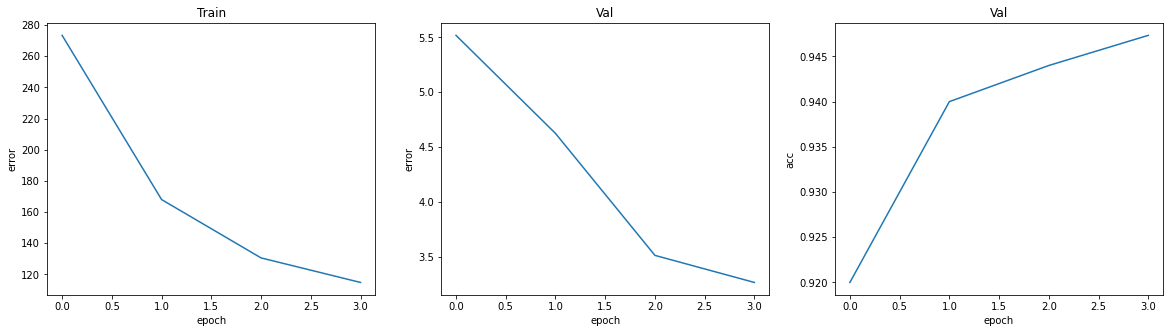

In [52]:
plot_acc_error(errors_train,errors_val,acc_val)

<h4>Как видно из графиков на train и val ошибка падает, val acc растет. Все хорошо<h4>

[2]
[0]
[2]
[0]
[0]
[0]
[2]


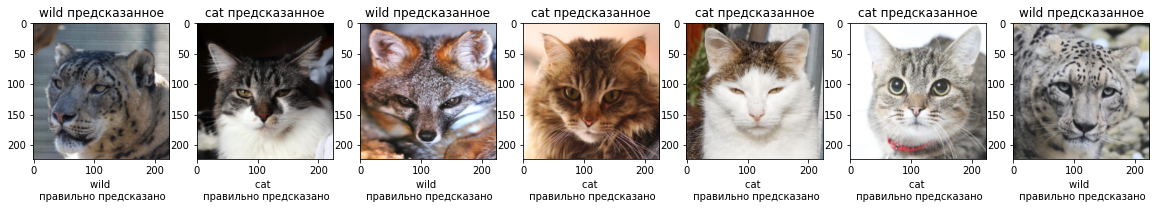

In [53]:
show_images(test_cnn_data,classes,network=final_net) 

Как видно из результатов, нейросеть хорошо распознает картинки в высоком разрешении, хорошо отличает кошек от лис и собак от волков

#Вывод

<h4><p>В результате проделанной работы можно заключить, что:<p><p>1) Полносвязные сети плохо справляются с классификацией изображений в высоком разрешении<p><p>2) Сверточные сети хорошо справляются с классификацией изображений в высоком разрешении.<p><p>3) Самые лучшие результаты показала модель vgg16 предобученная, однако кастомные ResNet и InceptionNet тоже показали хорошие результаты<p>4)После применения к модели дистиляции результаты стали лучше, учитель помог.</h4>